# Import Libraries

In [1]:
%matplotlib inline
from copy import deepcopy
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import sys
base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE

sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree.density_forest import *
from sklearn import decomposition

from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12229203664158089328
]


# Load Images

In [2]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


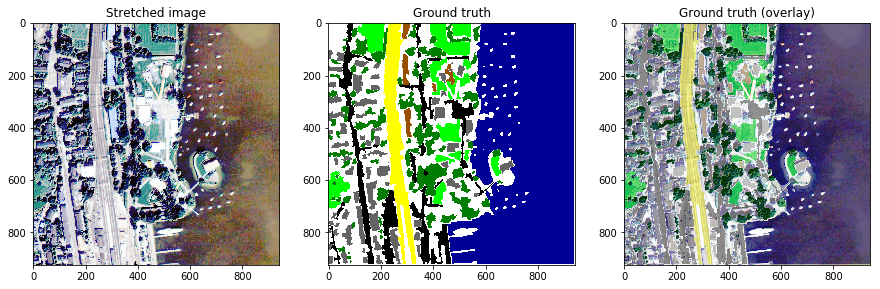

In [3]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 2
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [4]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)
    
gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


In [38]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


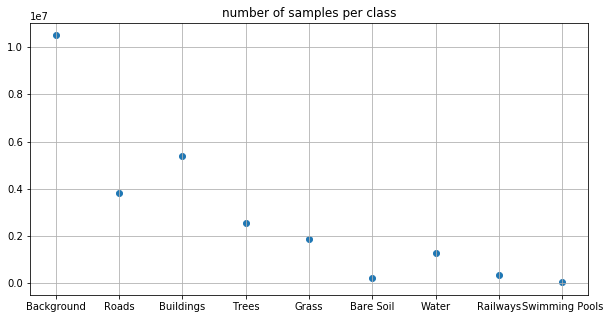

In [6]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [7]:
# Get patches

patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 120.07it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


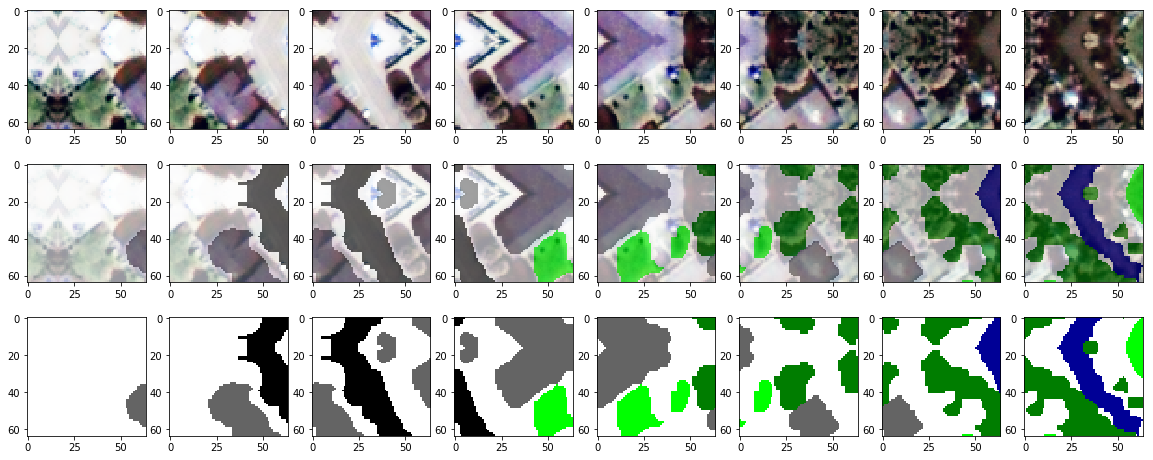

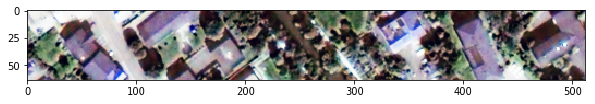

In [8]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth
    
# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

# Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [9]:
# create copies of original data
x_train_patches = x_train.copy()
x_val_patches = x_val.copy()
x_test_patches = x_test.copy()

y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [10]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [11]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_patches)
x_val = np.asarray(x_val_patches)
x_test = np.asarray(x_test_patches)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
class_to_remove = 3
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])


names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("class to remove: " + str(names[class_to_remove]))
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

class to remove: Trees
classes to keep: ['Roads', 'Buildings', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


## Train CNN

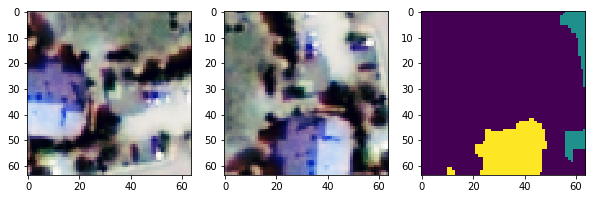

In [12]:
# data augmentation
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_patches[img_idx], y_train_label[img_idx], rf_h=True,
                                                       rf_v=True, rot=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train_patches[img_idx][..., :3])
axes[1].imshow(im_patches_vis[..., :3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [13]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator_dev(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

Instructions for updating:
Use the retry module or similar alternatives.


<Figure size 432x288 with 0 Axes>

In [14]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)

# save the model
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5')  # save model, weights
model_unet = load_model(path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5',
                        custom_objects={'fn': ignore_background_class_accuracy(0)})

# Prediction

In [15]:
# Prediction

# get prediction
y_pred = model_unet.predict(x_train, batch_size=20, verbose=1)
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

3897/3897 [==============================] - 134s 34ms/step


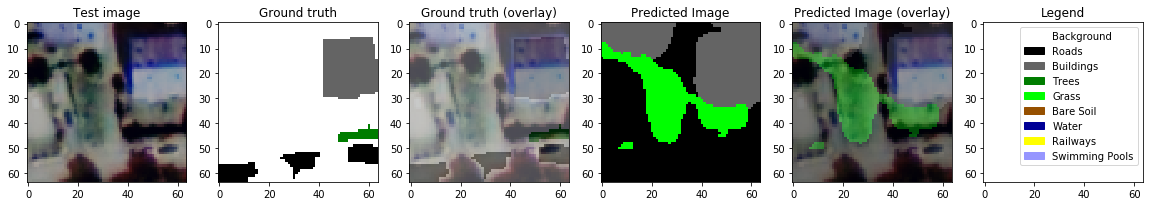

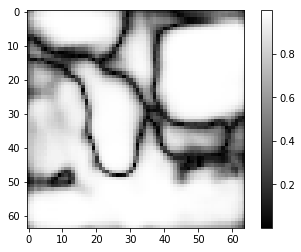

In [16]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_train[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_train_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

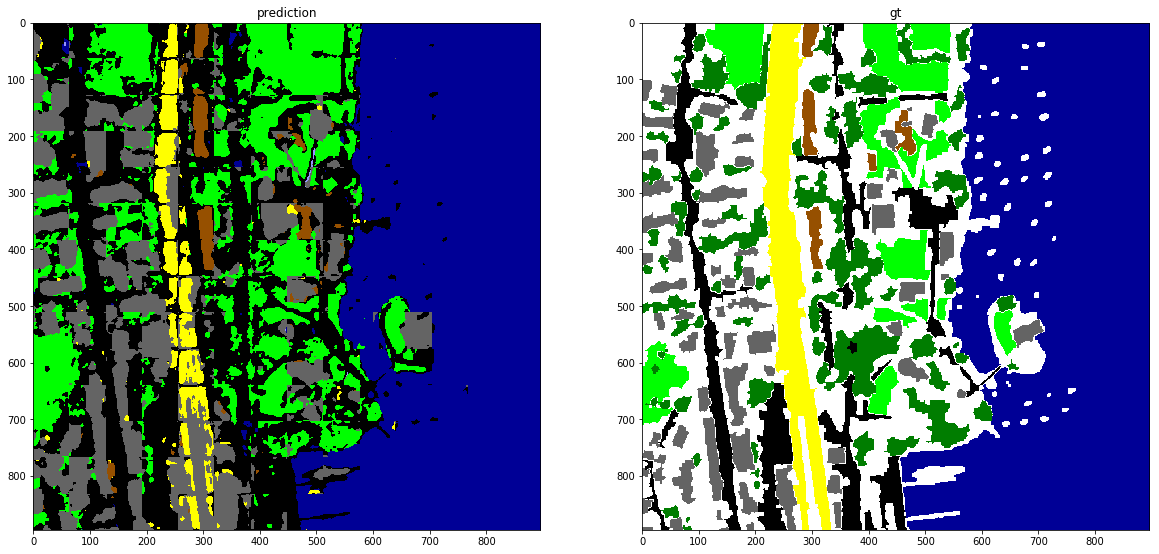

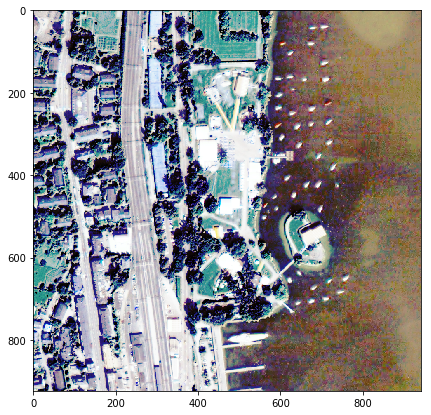

In [17]:
y_pred_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=0, patch_size=64,
                             stride=64) for i in range(0, 3)]
y_test_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_train_label, colors), img_idx=i, img_start=0, patch_size=64,
                             stride=64) for i in range(0, 3)]

_, axes = plt.subplots(1, 2, figsize=(20, 15))
img_idx = 2
axes[0].imshow(y_pred_im[img_idx])  # prediction
axes[1].imshow(y_test_im[img_idx])  # gt stitched together
[axes[i].set_title(["prediction", "gt", "image"][i]) for i in range(2)]
plt.show()

# show also original image
plt.figure(figsize=(7, 7))
plt.imshow(imgs[img_idx][:, :, :3])
plt.show()

# Accuracy metrics

In [18]:
# Accuracy metrics
y_pred_labels_im = gt_color_to_label(np.multiply(deepcopy(y_pred_im), 255), colors)
y_test_labels_im = gt_color_to_label(np.multiply(deepcopy(y_test_im), 255), colors)

y_pred_flattened = [subitem for sublist in y_pred_labels_im.flatten() for item in sublist for subitem in item]
y_test_flattened = [subitem for sublist in y_test_labels_im.flatten() for item in sublist for subitem in item]

y_pred_flattened = np.asarray(y_pred_flattened).astype('int')
y_test_flattened = np.asarray(y_test_flattened).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


In [19]:
# Class accuracy, average accuracy
print(metrics.classification_report(
    y_pred_flattened[filter_items],
    y_test_flattened[filter_items],
    target_names=np.asarray(labels)[classes_to_keep],
    digits=3))

# Overall accuracy
OA = metrics.accuracy_score(y_pred_flattened[filter_items], y_test_flattened[filter_items])
print("Overall accuracy: %.3f" % OA)

                precision    recall  f1-score   support

         Roads      0.938     0.834     0.883    295358
     Buildings      0.958     0.931     0.944    461491
         Grass      0.964     0.995     0.979    348810
     Bare Soil      0.882     0.959     0.919     73711
         Water      0.990     0.997     0.994    281930
      Railways      0.518     0.924     0.664     32402
Swimming Pools      0.908     0.970     0.938      4744

   avg / total      0.948     0.941     0.942   1498446

Overall accuracy: 0.941


# Certainty using Density Forest

In [20]:
from keras import backend as k

# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest

def get_activations_helper(model, layer_idx, img_patches, img_ids, batch_size=20, idx_begin=0, patch_size=64, stride=64, n_filters=32):
    """
    get activations for a set of patches
    :param model: model for which to extract activations
    :param layer_idx: layer index for which to extract activations
    :param img_patches: patches for which to extract activations (n_patches, patch_size, patch_size, n_bands)
    :param img_ids: indexes of images corresponding to the image patches (i.e., training, validation or test indexes)
    :param patch_size: size of the patches
    :param stride: number of overlapping pixels between patches
    :param n_filters: number of filters in the model layer to extract
    """
    act_imgs = []
    get_activations_keras = k.function([model.layers[0].input, k.learning_phase()], [model.layers[layer_idx].output, ])
    for img_idx in img_ids:
        patches_begin = get_offset(imgs, patch_size, stride, idx_begin, img_idx)
        patches_end = get_offset(imgs, patch_size, stride, idx_begin, img_idx + 1)
        act_im = np.empty((0, patch_size, patch_size, n_filters), float)
        for idx_patch in tqdm(np.arange(patches_begin,patches_end,batch_size)):
            end_batch = idx_patch+batch_size if idx_patch+batch_size<patches_end else patches_end
            im_batch = img_patches[idx_patch:end_batch]
            act_batch = get_activations_keras([im_batch, 0])[0]
            act_im = np.append(act_im, act_batch, axis=0)
        act_imgs.append(act_im)
    return np.asarray(act_imgs)

In [21]:
act_train = get_activations_helper(model_unet, layer_idx, x_train, ids_train, batch_size=80, idx_begin=0, 
                                  patch_size=64, stride=64, n_filters=32)

100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


In [22]:
act_train_concat = np.concatenate(act_train, axis=0)

# get activations for unseen class
filter_unseen = (y_train_label != 0) & (y_train_label == class_to_remove)
act_unseen = act_train_concat[filter_unseen]

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_seen = act_train_concat[filter_seen]

# also get all as 1D
act_all_train = act_train_concat[filter_seen == filter_seen]

del act_train_concat
del act_train

Variance explained by first 5 components: 0.97


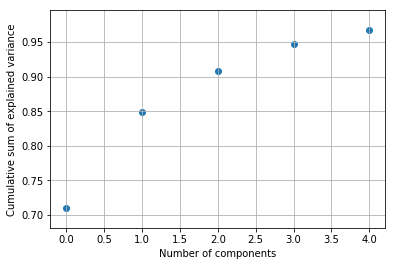

In [23]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=15)
pca.fit(act_seen)
n_components = np.alen(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_) < .95]) + 1
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_[:n_components])))

pca = decomposition.PCA(n_components=n_components)
pca.fit(act_seen)

act_seen = pca.transform(act_seen)
act_unseen = pca.transform(act_unseen)

# validation label
y_seen_1D = y_train_label[filter_seen]

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [24]:
# get activations for testing Density Forest
act_test = get_activations_helper(model_unet, layer_idx, x_test, ids_test, batch_size=80, idx_begin=16, 
                                  patch_size=64, stride=32, n_filters=32)

100%|██████████| 19/19 [00:52<00:00,  2.77s/it]


In [25]:
# remove the border effect by extracting overlapping regions of patches

def remove_overlap(patches, idx_imgs, patch_size, stride):
    """
    create non-overlapping patches from overlapping patches
    :param patches: overlapping patches
    :param idx_imgs: indexes of corresponding images
    :param patch_size: size of patches
    :param stride: central overlap between patches 
    :return patches_wo_overlap: new patches without overlap
    """
    patches_wo_overlap = []
    for idx, idx_im in enumerate(idx_imgs):
        act_im = convert_patches_to_image(imgs, patches[idx], img_idx=idx_im, 
                                          img_start=idx_im, patch_size=patch_size, stride=stride)
        patches_wo_overlap.append(get_padded_patches(act_im[np.newaxis], patch_size, patch_size))
        
    return np.asarray(patches_wo_overlap)
        
act_test_no_overlap = remove_overlap(act_test, ids_test, 64, 32)
# visualize an activation
#plt.imshow(act_test_no_overlap[0][..., 3])
#plt.show()

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


In [26]:
act_test = np.concatenate(act_test_no_overlap, axis=0)[y_test_nostride < np.infty]
act_test = pca.transform(act_test)

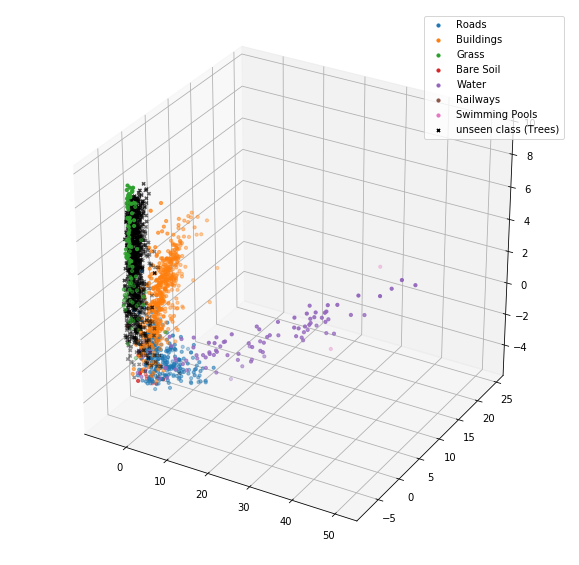

Variance explained by first 3 components: 0.91


In [27]:
# plot PCA points

# get data subset to show in figure
n_points = 1000
dataset_indices = np.arange(len(act_seen))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True, )
dataset_subset = act_seen[dataset_subset_indices, :]

dataset_indices = np.arange(len(act_unseen))
dataset_subset_indices_unseen = np.random.choice(dataset_indices, size=n_points, replace=True, )


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)
for class_keep in classes_to_keep:
    plot_data = act_seen[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    plot_color = y_seen_1D[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], cmap=plt.get_cmap('rainbow'), s=10,
               depthshade=True)

ax.scatter(act_unseen[dataset_subset_indices_unseen, 0], act_unseen[dataset_subset_indices_unseen, 1],
           zs=act_unseen[dataset_subset_indices_unseen, 2], c='black', s=10, marker='x', depthshade=True)
names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend)
plt.savefig("../Figures/pca_components_3d_"+names[class_to_remove]+".pdf", bboact_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## Train Density Forest

In [28]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train each tree: %i" % int(np.shape(act_seen)[0] * subset_data))
root_nodes_seen = density_forest_create(act_seen, n_classes, 20, subset_data, n_jobs=-1, verbose=10)

Number of points on which to train each tree: 8170


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    3.7s remaining:    3.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    4.7s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.8s finished


In [ ]:
# get probabilities for all images
n_jobs = 1  # for MacOS
patches_start = get_offset(imgs, 64, 64, 16, 16)
patches_end = get_offset(imgs, 64, 64, 16, 20)
probas = Parallel(n_jobs=n_jobs, verbose=1)(  # try for multiprocessing
    delayed(density_forest_traverse_x)(
        act_test[patch_idx * (patch_size * patch_size):(patch_idx + 1) * (patch_size * patch_size), :],
        root_nodes_seen, thresh=.1)
    for patch_idx in range(patches_start, patches_end + 1))

100%|██████████| 4096/4096 [00:00<00:00, 12701.99it/s]


100%|██████████| 4096/4096 [00:00<00:00, 12558.40it/s]


100%|██████████| 4096/4096 [00:00<00:00, 14551.80it/s]


100%|██████████| 4096/4096 [00:00<00:00, 11696.94it/s]


100%|██████████| 4096/4096 [00:00<00:00, 13769.93it/s]


100%|██████████| 4096/4096 [00:00<00:00, 13074.48it/s]


 80%|████████  | 16/20 [00:01<00:00, 11.97it/s]

In [30]:
n_patches = patches_end - patches_start
probas_seen_im = np.reshape(np.asarray(probas[:-1]), (n_patches, patch_size, patch_size))

# ad-hoc scaling of probabilities
# TODO replace by more rigorous standardization
# probas_seen_im = np.log(probas_seen_im)
# probas_seen_im = np.add(probas_seen_im, -np.nanmin(probas_seen_im[probas_seen_im!=-np.infty]))
# probas_seen_im = np.divide(probas_seen_im, np.nanmax(probas_seen_im[probas_seen_im!=np.infty]))

In [31]:
# get predictions without for y without stride to show side-by-side
y_pred_nostride = model_unet.predict(x_test_nostride, batch_size=20, verbose=1)
y_pred_nostride_label = get_y_pred_labels(y_pred_nostride, class_to_remove)

964/964 [==============================] - 30s 31ms/step


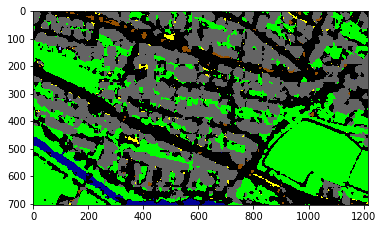

In [32]:
# get accuracy
y_pred_nostride_acc = get_accuracy_probas(y_pred_nostride)

y_pred_test_im = convert_patches_to_image(imgs, gt_label_to_color(y_pred_nostride_label, colors),
                                          img_idx=18, img_start=16, patch_size=64, stride=64)

y_pred_test_acc_im = convert_patches_to_image(imgs, y_pred_nostride_acc[..., np.newaxis],
                                              img_idx=18, img_start=16, patch_size=64, stride=64)

plt.imshow(y_pred_test_im)

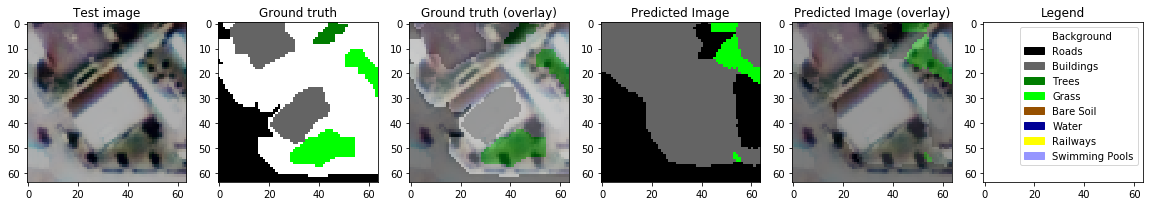

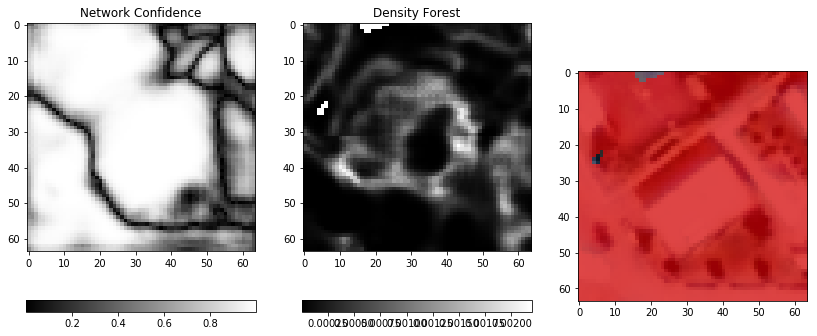

In [33]:
# plot prediction results with new uncertainty
#  %matplotlib inline
idx_im = get_offset(imgs, 64, 64, 16, im_idx)
idx_patch = 19
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test_nostride[idx_im + idx_patch][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_nostride[idx_im + idx_patch], colors)
fig_pred = gt_label_to_color(y_pred_nostride_label[idx_im + idx_patch], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = [n for n, c in legend_data]
axes[5].legend(handles, labels)

# show certitude by network
im_overlay = get_fig_overlay(fig_im, probas_seen_im[idx_patch], thresh=.93, opacity=.4)
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
f1 = axes[0].imshow(y_pred_nostride_acc[idx_im + idx_patch], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im[idx_patch], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal', spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
axes[2].imshow(im_overlay)
plt.show()

In [34]:
# convert patches to image
img_idx = 18
im_cert_out = convert_patches_to_image(imgs, probas_seen_im[..., np.newaxis],
                                       img_idx=img_idx, patch_size=64,
                                       stride=64, img_start=img_idx)

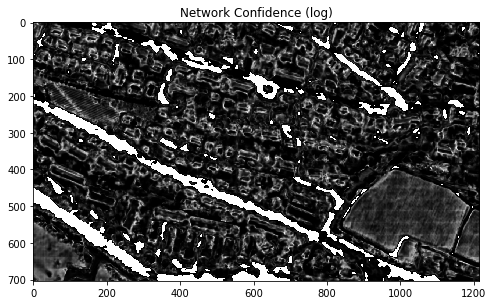

interactive(children=(FloatSlider(value=4.9999999999999996e-05, description='thresh', max=0.0001, min=1e-06, step=1e-06), Checkbox(value=False, description='save'), Output()), _dom_classes=('widget-interact',))

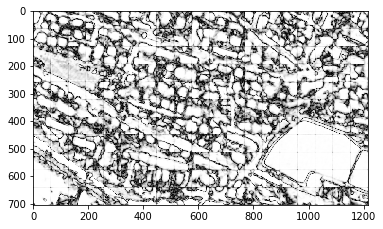

In [44]:
# show certitude by network
# image, overlay

fig = plt.figure(figsize=(8, 8))
plt.imshow(im_cert_out[..., 0], cmap='gray')
plt.title("Network Confidence (log)")
plt.show()

from ipywidgets import interact, FloatSlider
def fig_uncertainty(thresh, save=False):
    im_overlay = get_fig_overlay(imgs[img_idx][:im_cert_out.shape[0],:im_cert_out.shape[1],:3],im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(8,8))
    plt.imshow(im_overlay)
    plt.title("Low-Confidence Regions")
    if save:
        plt.savefig("../Figures/confidence_thresh_" + 
                    str(names[class_to_remove]).lower() + 
                    '_im_' + str(img_idx) + ".pdf", bboact_inches='tight', pad_inches=0)
    plt.show()
    
interact(fig_uncertainty,thresh=(1e-6,1e-4,1e-6))

plt.imshow(y_pred_test_acc_im[...,0],cmap='gray')

In [45]:
av_cert = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(im_cert_out[gt[img_idx][:im_cert_out.shape[0], :im_cert_out.shape[1]] == label]))
av_cert = np.asarray(av_cert)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

print("Average certainty seen class:\t\t%.4f" % cert_unseen)
print("Average certainty unseen classes:\t%.4f" % cert_seen)
print("Ratio seen class / unseen classes:\t%.4f" % (cert_seen / cert_unseen))

Average certainty within class:
          Roads: 0.00011
      Buildings: 0.00035
          Trees: 0.00019
          Grass: 0.00039
      Bare Soil: nan
          Water: 0.00009
       Railways: nan
 Swimming Pools: nan
Average certainty seen class:		0.0002
Average certainty unseen classes:	0.0002
Ratio seen class / unseen classes:	1.2360


Results for image 18

Class left out | Number of Components kept in PCA | Ratio certainty seen classes / unseen class
--- | --- | ---
Roads | 5 | 4.709
Buildings| 4 | 3.802
Trees| 5 | 1.2360
Grass| x | x
Bare Soil| x | x
Water| x | x
Railways| x | x
Swimming Pools| x | x